<a href="https://colab.research.google.com/github/osca-mwongera/HfT/blob/main/PG1/PRS/classification/lulc_ml/lulc_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Supervised Classification with Machine Learning Methods for Sentinel-2 Satellite Imagery

Michael Mommert, Stuttgart University of Applied Sciences, 2024

This Notebook introduces different supervised machine learning methods for pixel-wise classification. We will apply these methods to Sentinel-2 satellite images from the [*ben-ge-800* dataset](https://zenodo.org/records/12941231) to perform pixel-wise classification based on land-use/land-cover information.

In [1]:
%pip install numpy \
    scipy \
    matplotlib \
    rasterio \
    scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 33.1 MB/s eta 0:00:00


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import tarfile

## Data Download

We download the *ben-ge-800* dataset and unpack it:

In [3]:
!wget https://zenodo.org/records/12941231/files/ben-ge-800.tar.gz?download=1 -O ben-ge-800.tar.gz

tarfile = tarfile.open('ben-ge-800.tar.gz')  # open ben-ge-800 tarball
tarfile.extractall('./')  # extract tarball

--2024-11-04 22:03:30--  https://zenodo.org/records/12941231/files/ben-ge-800.tar.gz?download=1
Resolving zenodo.org (zenodo.org)... 188.184.103.159, 188.185.79.172, 188.184.98.238, ...
Connecting to zenodo.org (zenodo.org)|188.184.103.159|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 183201083 (175M) [application/octet-stream]
Saving to: ‘ben-ge-800.tar.gz’

ben-ge-800.tar.gz   100%[===================>] 174.71M  27.4MB/s    in 7.0s    

2024-11-04 22:03:38 (25.1 MB/s) - ‘ben-ge-800.tar.gz’ saved [183201083/183201083]



Ben-ge-800 contains 800 samples ...

Each image is represented by 12 TIF files, each containing a separate band. Note that some of these bands have different GSDs.

We read in the R, G and B band for a single scene:

In [4]:
sen2_path = 'ben-ge-800/sentinel-2/'
filename = 'S2B_MSIL2A_20180525T94030_7_51'
bands = ['B04', 'B03', 'B02']  # R, G, B

data = []
for band in bands:
    dataset = rasterio.open(os.path.join(sen2_path, filename, filename+'_'+band+'.tif'))
    data.append(dataset.read(1))
data = np.array(data)
data.shape

(3, 120, 120)

The data is now stored as a Numpy array, following the shape convention `[bands, height, width]`.

Let's display this image. In order to do so, we have to do two things:

1. we have to change the shape to `[height, width, bands]` (this particular shape is expected by matplotlib)
2. we have to normalize the pixel values (which vary on a large range) to a range from 0 to 1.

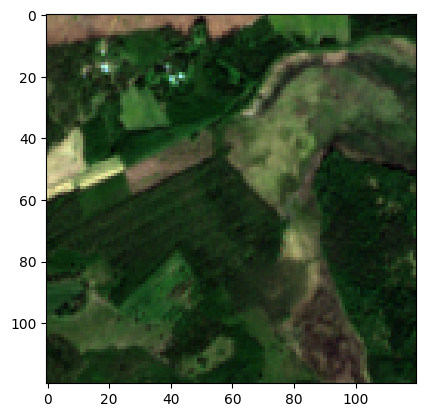

In [5]:
img = np.dstack(data)

# then we normalize the pixel values in such a way that they range from 0 (min) to 1 (max)
img = (img-np.min(img, axis=(0,1)))/(np.max(img, axis=(0,1)) - np.min(img, axis=(0,1)))

# now we can plot the image
plt.imshow(img)

This looks good.

Now, let's read in all scenes from the dataset. In this tutorial, we will not only use the RGB data, but also band 8, which contains NIR data. We will ignore the other bands, which saves us the effort of having to rescale those other bands (although this could be easily done with image interpolation techniques). Reading in all images takes a few seconds:

In [6]:
filelist = os.listdir(sen2_path)
bands = ['B04', 'B03', 'B02', 'B08']  # R, G, B, NIR

data = []
for filename in sorted(filelist):
    scene = []
    for band in bands:
        dataset = rasterio.open(os.path.join(sen2_path, filename, filename+'_'+band+'.tif'))
        scene.append(dataset.read(1))
    data.append(np.stack(scene, axis=0))
data = np.stack(data, axis=0)

Before we move on, we scale the data appropriately. For this purpose, we simply scale each band by the mean value in each band:

In [7]:
data = data/data.mean(axis=(0, 2, 3)).reshape(1, 4, 1, 1)
data.shape

(800, 4, 120, 120)

Now we can easily access any scene from our dataset:

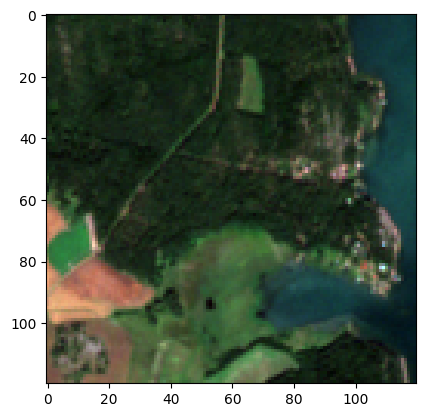

In [33]:
i = 385 # image index

img = np.dstack([data[i][0], data[i][1], data[i][2]])  # we extract the R, G, B bands for this scene

# then we normalize the pixel values in such a way that they range from 0 (min) to 1 (max)
img = (img-np.min(img, axis=(0,1)))/(np.max(img, axis=(0,1)) - np.min(img, axis=(0,1)))

# now we can plot the image
plt.imshow(img)

### Image cropping

In order to annotate ground-truth data (see below), we have to be able to extract pixels that belong to specific land-use/land-cover classes based on their coordinates. As you can see in the image above, the axis labels provide those coordinates. Note that the origin of these coordinates lies in the top left corner of the image. This is due to the fact that in Python, images are stored as arrays and those use matrix notation: each pixel is denoted by a pair of numbers that correspond to its row and column.

Therefore, we can extract the spectral properties of any pixel. Let's compare the properties of pixels that should be members of different land-use/land-cover classes:

In [9]:
print('water', data[i, :, 10, 110])
print('forest', data[i, :, 60, 60])
print('grassland', data[i, :, 100, 60])

water [0.1549684  0.42698751 0.4535954  0.00686251]
forest [0.15406215 0.29926417 0.25556228 0.77425259]
grassland [0.43046778 0.63861669 0.48235998 1.68414067]


Note the notation here. The array `data` has the shape `(800, 4, 120, 120)`. This means that it contains 800 images, each with 4 bands, a height of 120 pixels and width of 120 pixels. The notation to address an individual pixel is therefore `[image index, band, row, column]`. As an example, `data[i, :, 20, 115]` will provide us for the image with the index `i` (385 in this case) all bands (`:`) at the pixel at row 20 and column 115.

The output also requires some explanations. Naturally, there are 4 numbers (corresponding to the 4 different bands in our dataset). But what is the order of the bands? That order was decided upon when we created `data` (see above) and the order is `[R, G, B, NIR]`.

Now we can use this information to discuss the different pixel values that we just extracted:

* Water has its highest reflectivity in the B band (water appears blueish) and its lowest reflectivity in NIR.
* The forest pixel reflectivities are very low across all bands (forest appears dark); among the RGB values, G is highest (forest appears green) and NIR is much higher than for water (vegetation!).
* The grassland pixel is among features the highest reflectivities across all bands (appears lighter than other terrains) and has the highest reflectivity of all terrains in G and NIR (vegetation!).

We will leverage the different spectral properties to identify different land-use/land-cover classes in our dataset!

**Exercise**: extract band values for the same 3 classes from different locations in the same image.

In [10]:
# use this cell for the exercise
print('water', data[i, :, 20, 115])
print('forest', data[i, :, 20, 30])
print('grassland', data[i, :, 70, 60])

water [0.1549684  0.42698751 0.4535954  0.00686251]
forest [0.12506222 0.25264981 0.20467109 0.78232613]
grassland [0.28546811 0.49597676 0.31751678 1.59735011]


The problem is that spectral properties - even for the same classes or surface materials - can vary significantly!

Therefore, it makes a lot of sense to not just extract spectral properties for individual pixels, but for uniform image areas, instead. To do so, we have to use a slightly different approach: we use slicing across rows and columns to crop image areas.

For instance, to extract a rectangular area that is mostly covered by grassland, we can use the following syntax:

In [11]:
grassland_area = data[i, :, 75:100, 45:65]

To validate that we really extracted the correct area, we can plot it. To do so, we first have to extract the RGB values from the crop:

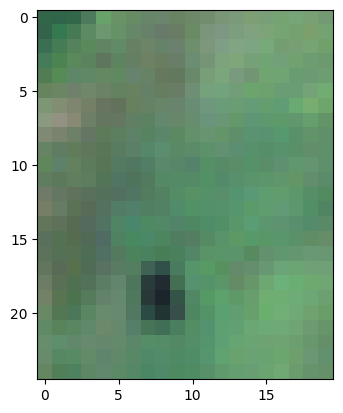

In [12]:
img = np.dstack([grassland_area[0], grassland_area[1], grassland_area[2]])
plt.imshow(img)

Nice. We now have the capability to select image regions and build a catalog of ground-truth data for training our models.

## Data Annotations

The availability of labeled examples forms the core of the supervised learning process, in which a model is trained based on these examples.

In the following, we will use the scene from above and label three regions from this image into separate classes. These classes will be `grassland`, `forest` and `water`.

We use the same method as above to extract pixel coordinates of rectangular regions containing either of these classes:

We find a rectangular area covering forest in the area enclosed by the point (0, 40) and (40, 0). Let's verify:

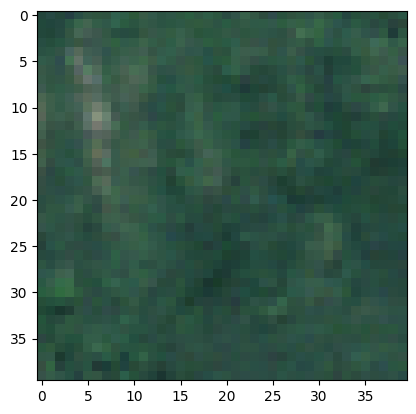

In [13]:
forest_area = data[i, :, 0:40, 0:40]
img = np.dstack([forest_area[0], forest_area[1], forest_area[2]])
plt.imshow(img)

And we find surface water enclosed by the points (110, 60) and (120, 0). Let's verify:

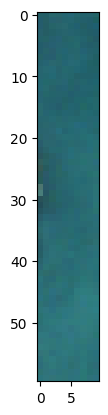

In [14]:
water_area = data[i, :, :60, 110:120]
img = np.dstack([water_area[0], water_area[1], water_area[2]])
plt.imshow(img)

Including the grassland area from above, we now defined three areas - on for each class. These areas will serve as training input data for our supervised learning approach.

We extract the pixel values from each area into separate arrays for further processing:

In [15]:
X_grassland = np.dstack(grassland_area).reshape(-1, 4)
X_forest = np.dstack(forest_area).reshape(-1, 4)
X_water = np.dstack(water_area).reshape(-1, 4)

X_grassland.shape, X_forest.shape, X_water.shape

((500, 4), (1600, 4), (600, 4))

Before we move on, we will have a look at the spectral distribution of pixels. Since it is impossible to plot a 4-dimensional dataset, we will only plot the

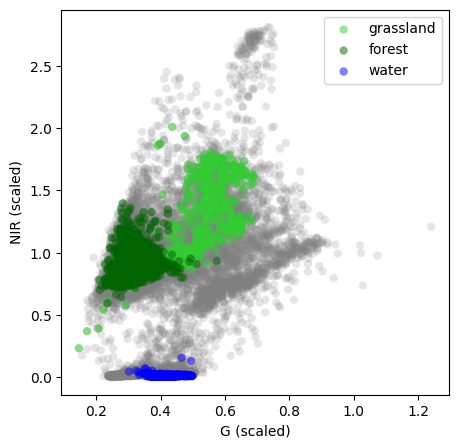

In [16]:
f, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(data[i, 1].flatten(), data[i, 3].flatten(), c='grey', edgecolor='none', alpha=0.2)
ax.set_xlabel('G (scaled)')
ax.set_ylabel('NIR (scaled)')

ax.scatter(X_grassland[:, 1], X_grassland[:, 3], c='limegreen', edgecolor='none', alpha=0.5, label='grassland')
ax.scatter(X_forest[:, 1], X_forest[:, 3], c='darkgreen', edgecolor='none', alpha=0.5, label='forest')
ax.scatter(X_water[:, 1], X_water[:, 3], c='blue', edgecolor='none', alpha=0.5, label='water')

ax.legend()

It becomes obvious that all three class occupy different spaces in their Green-Nearinfrared space. We will leverage this observation in the following.

But before we do so, we will compile a training dataset in which we combine the pixels with their corresponding class labels. The result of this will be one array, `X_data`, which we will use as input to our model and `y_data`, which will will contain the corresponding labels. Finally, we will split these arrays into our training, validation and test data split (70%/15%/15%) in a stratified fashion.

In [17]:
from sklearn.model_selection import train_test_split

# compile input and labels for previously annotated data
X_data = np.concatenate([X_grassland, X_forest, X_water], axis=0)
y_data = np.hstack([np.zeros(len(X_grassland)), np.ones(len(X_forest)), np.ones(len(X_water))*2])

# we split the entire dataset into a training (70%) and remain (30%) split; the remain fraction will be split into validation (50%) and test (50%)
X_train, X_remain, y_train, y_remain = train_test_split(X_data, y_data, train_size=0.7, shuffle=True, random_state=42, stratify=y_data)
X_val, X_test, y_val, y_test = train_test_split(X_remain, y_remain, train_size=0.5, shuffle=True, random_state=42, stratify=y_remain)

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape


((1889, 4), (1889,), (405, 4), (405,), (406, 4), (406,))

## Maximum Likelihood Classification

We start with a simple Maximum Likelihood Classification method to classify all pixels in our scene. The idea behind the method is simple. We assign each pixel, $x_i$, to that class $C_j \in (grassland, forest, water)$ that has the highest probability $P(C_J | x_i)$ of having the individual spectral characteristics of this pixel. We approximate this probability of belonging to a class $j$ through a multinormal distribution: $$P(C_j | x_i) = N(x_i | \mu_j, \Sigma_j)$$

In doing so, the multinormal distribution approximates the spectral characteristics of each class through mean colors ($\mu_j$) and corresponding covariances ($\Sigma_j$). Our first step is to compute these mean values and covariances for each class.

In [18]:
# compute mean pixel values for each band and class ([grassland, forest, water])
means = np.stack([np.nanmean(X_train[y_train==0], axis=0),
                  np.nanmean(X_train[y_train==1], axis=0),
                  np.nanmean(X_train[y_train==2], axis=0)], axis=0)


# compute covariance matrices for each class ([grassland, forest, water])
covs = np.stack([np.cov(X_train[y_train==0].transpose()),
                 np.cov(X_train[y_train==1].transpose()),
                 np.cov(X_train[y_train==2].transpose())], axis=0)

Let's see whether the mean values agree with the spectral areas of our three classes:

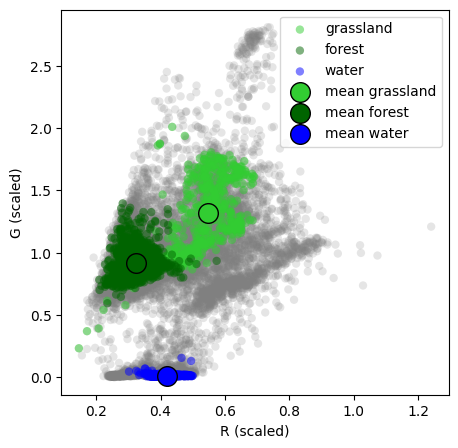

In [19]:
f, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(data[i, 1].flatten(), data[i, 3].flatten(), c='grey', edgecolor='none', alpha=0.2)
ax.set_xlabel('R (scaled)')
ax.set_ylabel('G (scaled)')

ax.scatter(X_grassland[:, 1], X_grassland[:, 3], c='limegreen', edgecolor='none', alpha=0.5, label='grassland')
ax.scatter(X_forest[:, 1], X_forest[:, 3], c='darkgreen', edgecolor='none', alpha=0.5, label='forest')
ax.scatter(X_water[:, 1], X_water[:, 3], c='blue', edgecolor='none', alpha=0.5, label='water')

ax.scatter(means[0][1], means[0][3], c='limegreen', s=200, edgecolor='black', label='mean grassland')
ax.scatter(means[1][1], means[1][3], c='darkgreen', s=200, edgecolor='black', label='mean forest')
ax.scatter(means[2][1], means[2][3], c='blue', s=200, edgecolor='black', label='mean water')

ax.legend()

Yes, the means are representative for the different classes.

Now, we can employs these means and covariances to find the most likely class of each pixel:

In [20]:
from scipy.stats import multivariate_normal

def maximum_likelihood_classifier(data, means, covs):
    """This function takes as input an array-like dataset (pixelwise band values), band mean values and corresponding covariances.
    The output consists of the most likely class for each pixel, as well as the probabilities for all classes"""
    p = []
    for j in range(3):
        p.append(multivariate_normal.pdf(data, mean=means[j], cov=covs[j]))
    return np.argmax(p, axis=0), np.array(p)

pred, prob = maximum_likelihood_classifier(np.dstack(data[i]).reshape(-1, 4), means, covs)

We can plot the result:

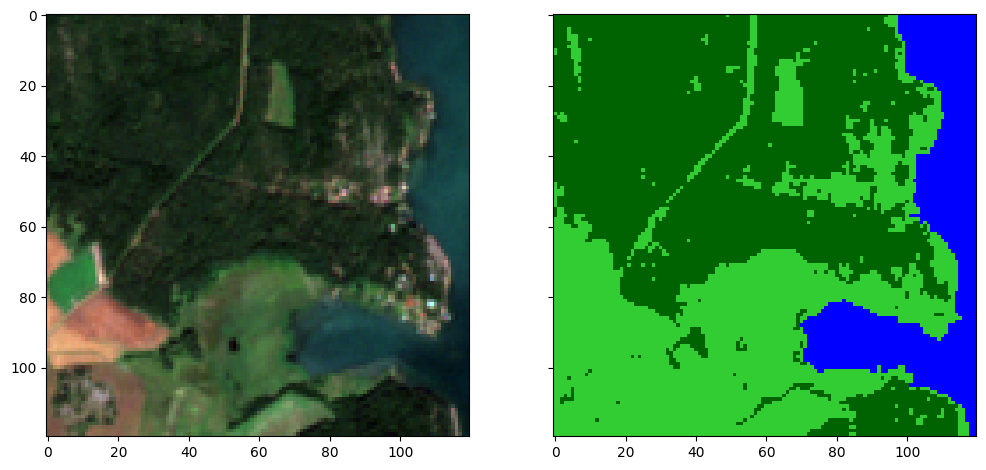

In [21]:
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

# create a colormap
colors = ['limegreen',  # grassland
          'darkgreen',  # forest
          'blue']  # water
cmap = LinearSegmentedColormap.from_list("cmap", colors)

# create a plot
f, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12, 6))

img = np.dstack([data[i][0], data[i][1], data[i][2]])  # we extract the R, G, B bands for this scene
img = (img-np.min(img, axis=(0,1)))/(np.max(img, axis=(0,1)) - np.min(img, axis=(0,1)))
ax[0].imshow(img)

ax[1].imshow(pred.reshape(120, 120), cmap=cmap)

This looks already pretty good!

**Exercise**: Apply the model to different image from our dataset. Does it work as well? If not, why?

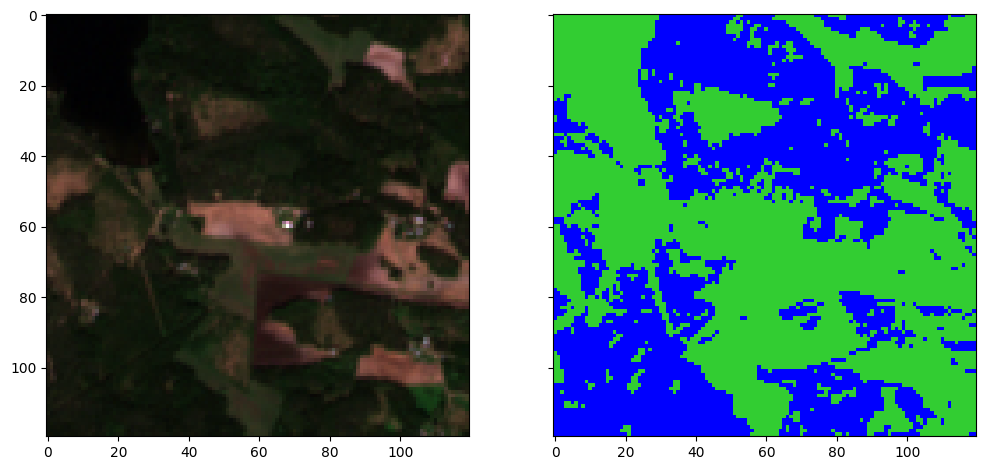

In [29]:
# use this cell for the exercise

# Changing the index variable alters the later exercises

pred, prob = maximum_likelihood_classifier(np.dstack(data[777]).reshape(-1, 4), means, covs)

# create a plot
f, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12, 6))

img = np.dstack([data[777][0], data[777][1], data[777][2]])  # we extract the R, G, B bands for this scene
img = (img-np.min(img, axis=(0,1)))/(np.max(img, axis=(0,1)) - np.min(img, axis=(0,1)))
ax[0].imshow(img)

ax[1].imshow(pred.reshape(120, 120), cmap=cmap)

# For image 777, the model does not perform well. The pixels are too dark (the image was captured in low light conditons compared to the training data).

## Model Evaluation

Qualitatively, the results look promising. Does the same apply to the quantitative results?

We can evaluate our model performance on our test dataset, which is independent from our training dataset. As our performance metric, we choose the accuracy metric.

In [30]:
from sklearn.metrics import accuracy_score

# compute predictions for our test dataset
pred, prob = maximum_likelihood_classifier(X_test, means, covs)

# compute accuracy score
print("accuracy:", accuracy_score(pred, y_test))

accuracy: 0.9729064039408867


This is a very good result! Let's see, whether we can improve on this result...

## k-Nearest Neighbor Classification

Maximum Likelihood is a rather simple classification model. We will now employ a nearest neighbor ($k=1$) model.



In [31]:
from sklearn.neighbors import KNeighborsClassifier

# instantiate the model
model = KNeighborsClassifier(1)

# "train" the model on the training dataset
model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

As we did before, we plot the prediction for the entire scene:

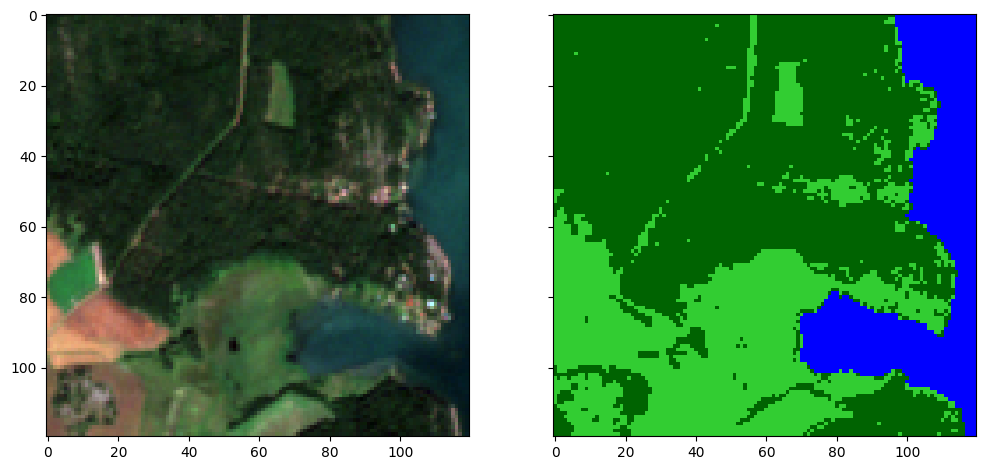

In [34]:
# predict classes for each pixel
pred = model.predict(np.dstack(data[i]).reshape(-1, 4))

f, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12, 6))

img = np.dstack([data[i][0], data[i][1], data[i][2]])  # we extract the R, G, B bands for this scene
img = (img-np.min(img, axis=(0,1)))/(np.max(img, axis=(0,1)) - np.min(img, axis=(0,1)))
ax[0].imshow(img)

ax[1].imshow(pred.reshape(120, 120), cmap=cmap)

The qualitative result also looks very good! What about the accuracy metric?

In [35]:
from sklearn.metrics import accuracy_score

pred = model.predict(X_test)
accuracy_score(pred, y_test)

0.9901477832512315

Well, the nearest neighbor classifier does indeed outperform the Maximum Likelihood model.

We can look at the mistakes the model makes using a confusion matrix:

In [36]:
from sklearn.metrics import confusion_matrix
# todo: add seaborn confusion matrix

confusion_matrix(pred, y_test)

array([[ 72,   1,   0],
       [  3, 240,   0],
       [  0,   0,  90]])

**Exercise**: We did not tune the hyperparameter ($k$) of our model. Train and evaluate the model for $k=5$, $k=10$ and $k=50$. What is the accuracy on the validation dataset for each of those parameters?

In [ ]:
# use this cell for the exercise

**Exercise**: Our training dataset is rather small. Add more data to our training dataset by extending the arrays `X_grassland`, `X_forest` and `X_water` with additional pixel areas (also from other images!).

In [ ]:
# use this cell for the exercise

**Exercise**: Replace the k-nearest neighbor model with a random forest model.

In [ ]:
# use this cell for the exercise

**Exercise**: Add an additional class to your set of classes: `snow`. You can use the image `i = 655` as a sample. Create this new class and corresponding training data. Train either of the previously discussed models and apply the model to the entire dataset. How many images in the entire dataset have snow in them based on your trained model?

# use this cell for the exercise